In [4]:
# -*- coding: utf-8 -*-
"""
Created on Sun May  4 18:53:06 2025

@author: maxim
"""

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mst
from cycler import cycler
from scipy.signal import savgol_filter
from datetime import datetime
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import fmin, minimize
import glob
import matplotlib.lines as mlines

import math
from scipy.signal import savgol_filter, find_peaks
from scipy.fft import fft

def get_var(table):
    t = table['Timeh']
    T = table['T1C']
    I = table['IA']
    U = table['UV']
    return np.array(t), np.array(T), np.array(I), np.array(U)

def create_dataset(table, segment):
    t, T, I, U = get_var(table)

    punkt_start = []
    punkt_end = []

    for i in range(5, len(t) - 6):
        if I[i] == 0 and I[i-5] == 0 and I[i+1] != 0:
            punkt_start.append(i)
        elif I[i] == 0 and I[i+5] == 0 and I[i-1] != 0:
            punkt_end.append(i)

    idx_start = punkt_start[segment - 1]
    idx_end = punkt_end[segment - 1]

    return (t[idx_start:idx_end+1], T[idx_start:idx_end+1], 
            I[idx_start:idx_end+1], U[idx_start:idx_end+1])

def smooth_temperature(T):
    window_size = 401  # muss ungerade sein
    degree = 1
    if len(T) > 100:
        if window_size > len(T):
            window_size = len(T) if len(T) % 2 != 0 else len(T) - 1
        T_smoothed = savgol_filter(T, window_size, degree)
    else:
        T_smoothed = np.mean(T) * np.ones_like(T)
    return T_smoothed

def fastfourier(T, f_from, f_to):
    N = len(T)
    T_F = fft(T)
    T_F = np.abs(T_F[:N // 2])
    T_F = (T_F / N) * 2

    Fs = 10  # Datenpunkte pro Sekunde
    f = np.linspace(0, Fs / 2, N // 2)

    f_begin = next((n for n, val in enumerate(f) if val >= f_from), 0)
    f_end = next((n for n, val in enumerate(f) if val >= f_to), len(f)-1) - 1

    return T_F[f_begin:f_end+1], f[f_begin:f_end+1]

def find_peaks_custom(T_F, x):
    min_peak_height = 0.0001
    peaks, properties = find_peaks(T_F, height=min_peak_height)

    sorted_indices = np.argsort(properties['peak_heights'])[::-1]
    sorted_peaks = peaks[sorted_indices]
    sorted_heights = properties['peak_heights'][sorted_indices]

    if len(sorted_peaks) < x:
        print('Warnung: Nicht genügend Peaks gefunden! Rückgabe mit NaN.')
        return np.nan, np.nan
    else:
        return sorted_peaks[x - 1], sorted_heights[x - 1]

def normalize(t, T, I, f, from_frac, periods):
    t = np.array(t)
    T = np.array(T)
    I = np.array(I)

    start_index = None
    for i in range(int(len(T) * from_frac), len(T) - 2):
        if I[i-1] <= 0 and I[i] <= 0 and I[i+1] >= 0 and I[i+2] >= 0:
            start_index = i + 1
            break

    if start_index is None:
        raise ValueError('Startpunkt konnte nicht gefunden werden!')

    end_index = int(start_index + periods * (1 / f) * 10)

    if end_index >= len(t):
        end_index = len(t) - 1  # Schutz gegen Indexüberschreitung

    t_seg = t[start_index:end_index + 1]
    T_seg = T[start_index:end_index + 1]
    I_seg = I[start_index:end_index + 1]

    t_normalized = (t_seg - t_seg[0]) / (t_seg[-1] - t_seg[0])
    T_normalized = T_seg - np.mean(T_seg)

    return t_normalized, T_normalized, I_seg

def calculate_delta_T(T, freq):
    T_F, f = fastfourier(T, 0.001, 0.1)  # FFT: Funktion musst du definieren

    best_f = f[0]
    f_index = 0
    for n in range(len(f)):
        if abs(f[n] - freq) < abs(best_f - freq):
            best_f = f[n]
            f_index = n
        if f[n] > freq:
            break

    delta_T = T_F[f_index]

    T_smoothed = smooth_temperature(T)  # Funktion musst du auch definieren

    if len(T_smoothed) == 1:
        fail = 1  # not used further, placeholder

    # Steigung (linearer Trend pro Punkt)
    increase = (T_smoothed[0] - T_smoothed[-1]) / len(T)

    quarter_period_index = round(1 / freq / 4 * 10)
    three_quarter_period_index = round(1 / freq * 3 / 4 * 10)

    Tq1 = T_smoothed[quarter_period_index] - increase * quarter_period_index
    Tq3 = T_smoothed[three_quarter_period_index] - increase * three_quarter_period_index

    if Tq1 <= Tq3:
        vz = -1
    else:
        vz = 1

    delta_T = delta_T * vz

    return delta_T


def calculate_delta_T_irreversible(T, freq):
    T_F, f = fastfourier(T, 0.001, 0.1)
    peak_freq, peak_value = find_peaks_custom(T_F, 2)
    T_smoothed = smooth_temperature(T)
    return peak_value

def find_all_segments(T, I, freq, G_th, periods):
    total_periods = math.floor(len(T) / 10 / (1 / freq))
    total_segments = math.floor(total_periods / periods)

    start_indices_I = np.linspace(0, total_segments * periods * 10 * (1 / freq), total_segments + 1)

    phase_phi = np.angle(G_th)  # in radians
    delta_t = abs(phase_phi / (2 * np.pi * freq))  # time shift due to phase

    start_indices_T = start_indices_I + delta_t * 10

    if start_indices_T[-1] >= len(I):  # Not enough data
        start_indices_T = start_indices_T[:-1]
        start_indices_I = start_indices_I[:-1]

    cutoff_start = (start_indices_I[0] + (0.5 * periods) * 10 * (1 / freq)) / len(I)
    cutoff_end = (start_indices_I[-1] - (0.5 * periods) * 10 * (1 / freq)) / len(I)

    if np.mean(I) < 0.1:  # discharge (negative DC current)
        cutoff_start = 1 - cutoff_start
        cutoff_end = 1 - cutoff_end

    return start_indices_I, start_indices_T, cutoff_start, cutoff_end

def calculate_deltaS_in_SOC_resolution(T, I, freq, G_th, periods):
    start_indices_I, start_indices_T, cutoff_start, cutoff_end = find_all_segments(T, I, freq, G_th, periods)

    delta_S = []
    mean_T_all = []
    for n in range(len(start_indices_I) - 1):
        idx_T_start = int(round(start_indices_T[n]))
        idx_T_end = int(round(start_indices_T[n + 1]))
        idx_I_start = int(round(start_indices_I[n]))
        idx_I_end = int(round(start_indices_I[n + 1]))

        T_seg = T[idx_T_start:idx_T_end]
        I_seg = I[idx_I_start:idx_I_end]

        delta_T = calculate_delta_T(T_seg, freq)
        delta_St, mean_T = calculate_deltaS(T_seg, I_seg, delta_T, G_th)

        delta_S.append(delta_St)
        mean_T_all.append(mean_T)

    return delta_S, cutoff_start, cutoff_end, mean_T_all

def calculate_deltaS(T, I, delta_T, G_th):
    FK = 96485.332  # Faraday constant
    I_max = (-np.min(I) + np.max(I)) / 2
    mean_T = np.mean(T)
    delta_S = delta_T * FK / (I_max * (mean_T + 273.15) * abs(G_th))
    return delta_S, mean_T

def calculate_deltaT_in_SOC_resolution(T, I, freq, G_th, periods):
    start_indices_I, start_indices_T, cutoff_start, cutoff_end = find_all_segments(T, I, freq, G_th, periods)

    delta_T = []
    mean_T = []
    for n in range(len(start_indices_I) - 1):
        idx_start = int(round(start_indices_T[n]))
        idx_end = int(round(start_indices_T[n + 1]))

        T_seg = T[idx_start:idx_end]
        mean_T.append(np.mean(T_seg))
        delta_T.append(calculate_delta_T(T_seg, freq))

    return delta_T, cutoff_start, cutoff_end, mean_T

def calculate_deltaT_irreversible_in_SOC_resolution(T, I, freq, G_th, periods):
    start_indices_I, start_indices_T, cutoff_start, cutoff_end = find_all_segments(T, I, freq, G_th, periods)

    delta_T = []
    for n in range(len(start_indices_I) - 1):
        idx_start = int(round(start_indices_T[n]))
        idx_end = int(round(start_indices_T[n + 1]))

        T_seg = T[idx_start:idx_end]
        delta_T.append(calculate_delta_T_irreversible(T_seg, freq))

    return delta_T, cutoff_start, cutoff_end

def calculate_Q_from_deltaS(T, I, freq, deltaS):
    T_F, f = fastfourier(T, 0.001, 0.01)
    peak_freq, peak_value = find_peaks_custom(T_F, 1)

    FK = 96485.332
    I_amp = (-np.min(I) + np.max(I)) / 2
    Q_rev = I_amp * peak_value * deltaS / FK

    return Q_rev

def calculate_Gth(T, I, freq, deltaS):
    T_F, f = fastfourier(T, 0.001, 0.01)
    peak_freq, peak_value = find_peaks_custom(T_F, 1)

    FK = 96485.332  # Faraday constant
    I_amp = (-np.min(I) + np.max(I)) / 2
    Q_rev = I_amp * (np.mean(T) + 273.15) * deltaS / FK

    delta_t = calculate_phase_delay(T, I, freq)
    phase_phi = -delta_t * 2 * np.pi * freq

    G_th = (peak_value / Q_rev) * np.exp(1j * phase_phi)  # complex value
    return G_th

def calculate_phase_delay(T, I, freq):
    T_smooth = smooth_temperature(T)

    total_periods = int(np.floor(len(T) / 10 / (1 / freq)))
    start_indices_I = np.linspace(0, total_periods * 10 * (1 / freq), total_periods + 1)

    delta_t_list = []
    for n in range(len(start_indices_I) - 1):
        idx_start = int(round(start_indices_I[n]))
        idx_end = int(round(start_indices_I[n + 1]))
        segment = T_smooth[idx_start:idx_end]

        max_t = np.max(segment)
        index_max = np.argmax(segment)

        delta_t_list.append(index_max - 0.25 * 10 * (1 / freq))

    delta_t = np.mean(delta_t_list) / 10
    return delta_t

def standardabweichung(deltaT1, SoC1, deltaT2, SoC2, deltaT3, SoC3):
    datapoints = min(len(SoC1), len(SoC2), len(SoC3))

    if SoC1[0] < SoC1[1]:
        lastSoC = min(SoC1[-1], SoC2[-1], SoC3[-1])
        firstSoC = max(SoC1[0], SoC2[0], SoC3[0])
    else:
        lastSoC = max(SoC1[-1], SoC2[-1], SoC3[-1])
        firstSoC = min(SoC1[0], SoC2[0], SoC3[0])

    SoC_common = np.linspace(firstSoC, lastSoC, datapoints)

    interp1 = interp1d(SoC1, deltaT1, fill_value="extrapolate")
    interp2 = interp1d(SoC2, deltaT2, fill_value="extrapolate")
    interp3 = interp1d(SoC3, deltaT3, fill_value="extrapolate")

    data1 = interp1(SoC_common)
    data2 = interp2(SoC_common)
    data3 = interp3(SoC_common)

    matrix_data = np.vstack([data1, data2, data3])

    error = np.std(matrix_data, axis=0)
    deltaT_mean = np.mean(matrix_data, axis=0)

    return deltaT_mean, SoC_common, error

def used_capacity(t, T, I, U):
    t_intervals = np.diff(t, prepend=t[0])
    Ah = np.sum(I * t_intervals)
    return Ah

def load_table(file,names):
    if names=="alt":
        spaltenköpfe=["Timeh", "DataSet", "Date", "Time", "Line", "Command", "UV", "IA", "AhAh", "T1C", "T2C", "CycCount", "State"]
    elif names=="neu":
        spaltenköpfe=["Timeh", "DataSet", "Date", "Time", "Line", "Command", "UV", "IA", "AhAh","AhStep", "T1C", "T2C", "CycCount", "State"]
    else:
        print("Fehler: Daten einlesen fehlgeschlagen, da unkorrekte Bezeichnung für header (alt/neu) ")
    df = pd.read_csv(
        file,
        sep=" ",
        header=13,
        names=spaltenköpfe,
        dtype={"Command": "category"},
        encoding="latin1"
    )
    # Parse Date and Time separately
    df['Date'] = pd.to_datetime(df['Date'], format=date_format, dayfirst=True)
    df['Time'] = pd.to_datetime(df['Time'], format=time_format).dt.time
    # Combine to Datetime
    df['Datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['Date'], row['Time']), axis=1)
    return df



Layout der Plots

In [5]:
from cycler import cycler
"""
Plot Farbeinstellungen
"""
plt.style.use('seaborn-v0_8')

default_cycler = (cycler(color=['#cc0000', '#22a15c', '#ff8000', '#00a6b3']))
plt.rc('lines', linewidth=1.5)
plt.rc('axes', prop_cycle=default_cycler)
plt.rcParams["figure.figsize"] = (9,7)
plt.rcParams["legend.fontsize"] = 18
fontsize = 20
labelsize=20

Laden der Daten

In [ ]:


load_tables = 0
if load_tables == 1:
    dir_path = r"C:\Users\maxim\Nextcloud\Shared\Austausch_Max\Projekt_Entropie\TIS_delS\Daten"
    
    date_format = "%d.%m.%Y"
    time_format = "%H:%M:%S"
    

    table_b05_3f_25 = load_table(dir_path + "\\CUB21NMC46_05_TISEnt_25deg.txt",names="alt")
    table_b05_3f_45 = load_table(dir_path + "\\CUB21NMC46_05_TISEnt_45deg.txt",names="alt")
    table_b05103_3f_25 = load_table(dir_path + "\\CUB21NMC103_07_TISEnt_25deg.txt",names="alt")
    table_b05103_3f_45 = load_table(dir_path + "\\CUB21NMC103_05_TISEnt_45deg.txt",names="alt")
    table_b0646_1f_45_60SOC = load_table(dir_path + "\\CUB23NMC46_06_Gth_f0,0018_iso_SOC60_T45.txt",names="alt")
    table_b0646_1f_45_70SOC = load_table(dir_path + "\\CUB23NMC46_06_Gth_f0,0018_iso_SOC70_T45.txt",names="alt")
    
    table_b05_46ah_25C = load_table(dir_path + "\\CUB21NMC46_05_TISEnt_fC_25deg.txt",names="alt")
    table_b05_46ah_35C = load_table(dir_path + "\\CUB21NMC46_05_TISEnt_fC_35deg.txt",names="alt")
    table_b05_46ah_45C = load_table(dir_path + "\\CUB21NMC46_05_TISEnt_fC_45deg.txt",names="alt")
    
    table_b06_46ah_45C_iso = load_table(dir_path + "\\CUB23NMC46_06_TISEnt_fC_45C_iso.txt",names="alt")
    
    table_b05_103ah_45C = load_table(dir_path + "\\CUB21NMC103_05_TISEnt_fC_45deg.txt",names="alt")
    table_b07_103ah_25C = load_table(dir_path + "\\CUB21NMC103_07_TISEnt_25deg.txt",names="alt")
    table_b06_46ah_45C = load_table(dir_path + "\\CUB23NMC46_06_TISEnt_fC_45C_iso.txt",names="alt")
    
    table_b01_60ah_45C_test1 = load_table(dir_path + "\\CUB23NMC60_01_TISEnt_fC_45C_iso.txt",names="alt")
    table_b01_60ah_45C_test2 = load_table(dir_path + "\\CUB23NMC60_01_TISEnt_fC_45C_iso_test2.txt",names="alt")
    table_b01_60ah_45C_test3 = load_table(dir_path + "\\CUB23NMC60_01_TISEnt_fC_45C_iso_test3.txt",names="alt")

    data_46ah_06_preTISdS=load_table(dir_path + "\\CUB21NMC4606_TA_preTISdS.txt",names="neu")
    data_46ah_6_delSage2=load_table(dir_path+"\\CUB21NMC4606_TA_delSage2.txt",names="neu")


Gth_46_25 = [0.28307575131427143 - 0.5694557119353795j, 0.0992090029044072 - 0.40013241202679706j, 0.024002359615499746 - 0.24578265766603566j,
             -0.0030660659402848107 - 0.14356448711714556j, -0.010249060903123176 - 0.08107120127440416j, -0.01012430506907814 - 0.047552355192110395j,
             -0.008980603120555857 - 0.02313346274695103j]

Gth_46_45 = [0.2532267200980727 - 0.5650169509537537j, 0.0590110205070614 - 0.39987708471975475j, -0.017563092286832276 - 0.22521967695877096j,
             -0.02635658424976652 - 0.11747668341246544j, -0.018767355457237227 - 0.06161260935553563j, -0.014382020658637041 - 0.028163425855762814j,
             -0.013379929492597975 - 0.013742360026182825j]

Gth_46_35 = [0.24890973495692773 - 0.5512146563008099j, 0.07596439254808957 - 0.3826077244792156j, 0.002191750911481564 - 0.23200025649169576j,
             -0.019213739855514552 - 0.1308301007428555j, -0.020026144435208813 - 0.07015925721576324j, -0.016323794780100237 - 0.03774281578494263j,
             -0.011422280225085232 - 0.014449789594029462j]

Gth_103_25 = [0.15735620830347402 - 0.16353142529774903j, 0.08553522231150656 - 0.1509780728192783j, 0.024858530624392663 - 0.11010546613591111j,
              0.0033241837949395856 - 0.07187419191540458j, -0.009404413764513904 - 0.04075467537988922j, -0.008489988628070473 - 0.020262491427831934j,
              -0.009076228542060959 - 0.011194078414764965j]

Gth_103_45 = [0.146719737649765 - 0.165217467815328j, 0.0692100405567881 - 0.155427073896046j, 0.00483831559170772 - 0.103142513851435j,
              -0.00920174705914652 - 0.0596203779538508j, -0.0127376247750700 - 0.0304060451916149j, -0.00875154305754080 - 0.0112962075739439j,
              -0.00983963730154681 - 0.00522012794028712j]

# Potentiometrische Daten
x = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
y103discharge = np.array([-37.00817797, -10.92754915, -5.044584463, -0.921328644, 11.19652438, 16.21210611, 15.27259824, 3.582676538, 3.3937416,
                          2.389707567, -0.056305578])

y103charge = np.array([-41.92390749, -28.78441467, -10.68100056, -4.180697691, 1.161323476, 6.94740051, 12.4774764, 0.863458268, 1.274463469,
                       0.746585476, -0.550593388])

y46discharge = np.array([-43.7927135, -19.30708741, -10.13751637, -5.187258392, 3.562153227, 11.75474836, 13.21245363, 11.88319875, -0.763879071,
                         -2.829012746, -6.834208778])

y46charge = np.array([-46.6653468, -35.14942003, -16.13615755, -10.52189454, -3.653678571, 4.172180624, 7.10592633, 8.101878869, -2.798217224,
                      -5.031914623, -7.57333161])

GL = np.array([-53.5, -42])



<Figure size 900x700 with 0 Axes>

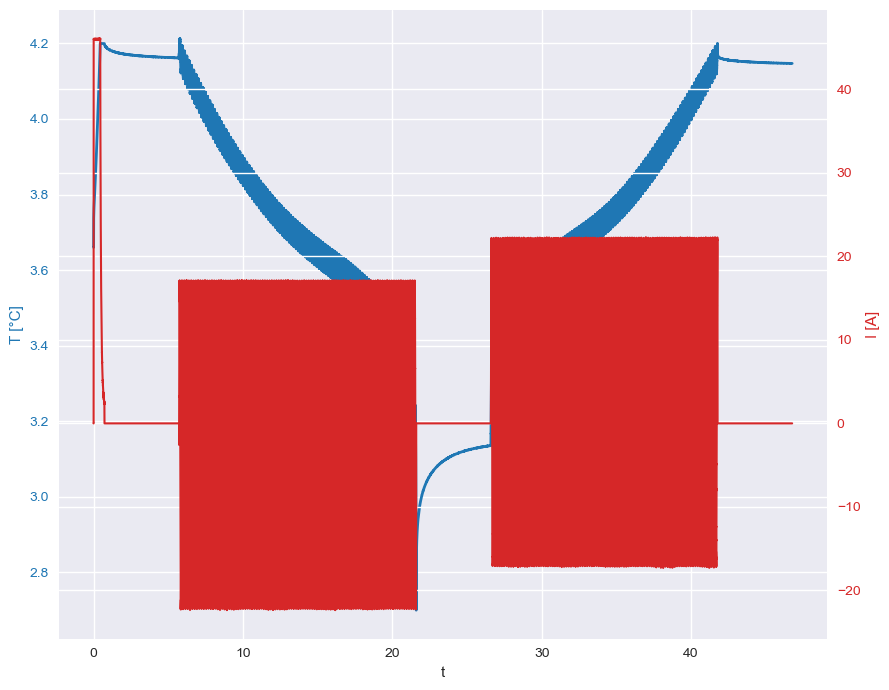

In [13]:
"""Plotting specifics"""

t, T, I, U = get_var(data_46ah_6_delSage2)  # Funktion muss wie in MATLAB definiert sein

# Plot
plt.figure()
fig, ax1 = plt.subplots()

color1 = 'tab:blue'
ax1.set_xlabel('t')
ax1.set_ylabel('T [°C]', color=color1)
# T_smooth = smooth_temperature(T)  # falls gewünscht
# ax1.plot(t, T_smooth, linewidth=2)
ax1.plot(t, U, linewidth=2, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('I [A]', color=color2)
ax2.plot(t, I, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.show()


#Auskommentierte plots aus Matlab weggelassen
#%%


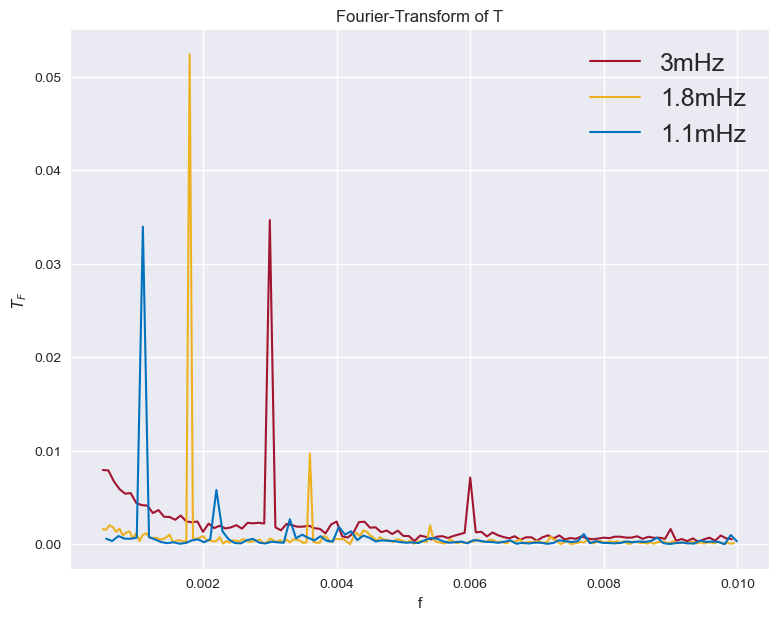

In [8]:
"""Plotting Fourier"""

plt.figure()
plt.title("Fourier-Transform of T")
plt.xlabel("f")
plt.ylabel("$T_{F}$")


t, T, I, U = create_dataset(table_b05_3f_25, 1)
T_F, f = fastfourier(T, 0.0005, 0.01)
plt.plot(f, T_F, color=[0.6350, 0.0780, 0.1840], label="3mHz")

# Plot 5
t, T, I, U = create_dataset(table_b05_3f_25, 2)
T_F, f = fastfourier(T, 0.0005, 0.01)
plt.plot(f, T_F, color=[0.9290, 0.6940, 0.1250], label="1.8mHz")

# Plot 6 + find_peaks (für Info)
t, T, I, U = create_dataset(table_b05_3f_25, 3)
T_F, f = fastfourier(T, 0.0005, 0.01)
peak_freq, peak_value = find_peaks(T_F, 1)
plt.plot(f, T_F, color=[0, 0.4470, 0.7410], label="1.1mHz")

plt.legend()
plt.grid(True)
plt.show()
#%%


Fourieranalyse der neuen Daten

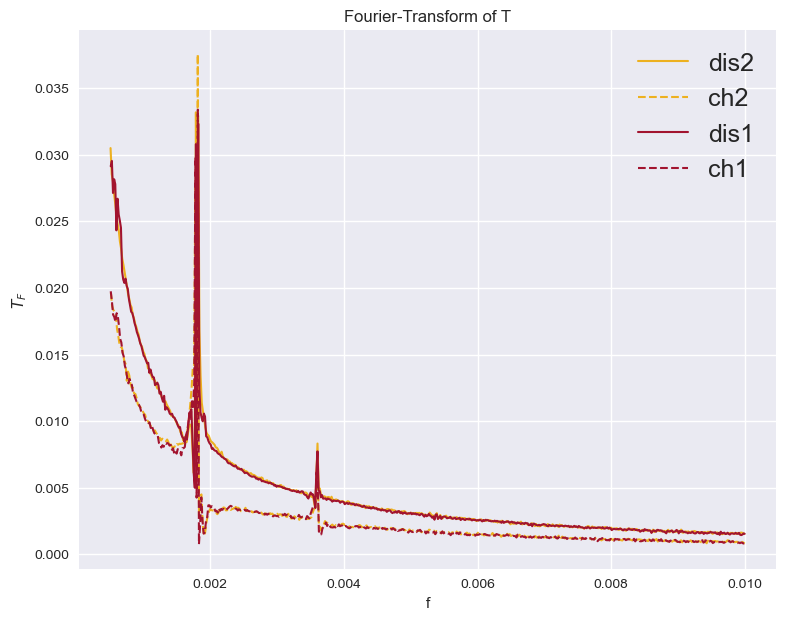

In [9]:
"""Fourier neue Daten"""
plt.figure()
plt.title("Fourier-Transform of T")
plt.xlabel("f")
plt.ylabel("$T_{F}$")

# data_46ah_6_delSage2
t, T, I, U = create_dataset(data_46ah_6_delSage2, 2)
T_F, f = fastfourier(T, 0.0005, 0.01)
plt.plot(f, T_F, color=[0.9290, 0.6940, 0.1250], label="dis2")

t, T, I, U = create_dataset(data_46ah_6_delSage2, 3)
T_F, f = fastfourier(T, 0.0005, 0.01)
plt.plot(f, T_F,"--", color=[0.9290, 0.6940, 0.1250], label="ch2")

# data_46ah_06_preTISdS
t, T, I, U = create_dataset(data_46ah_06_preTISdS, 2)
T_F, f = fastfourier(T, 0.0005, 0.01)
plt.plot(f, T_F, color=[0.6350, 0.0780, 0.1840], label="dis1")

t, T, I, U = create_dataset(data_46ah_06_preTISdS, 3)
T_F, f = fastfourier(T, 0.0005, 0.01)
plt.plot(f, T_F,"--", color=[0.6350, 0.0780, 0.1840], label="ch1")


plt.legend()
plt.grid(True)
plt.show()


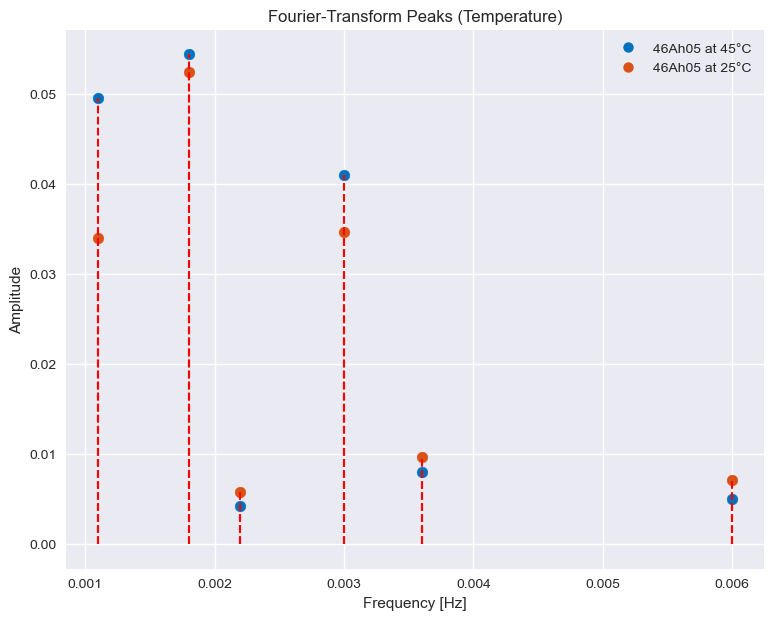

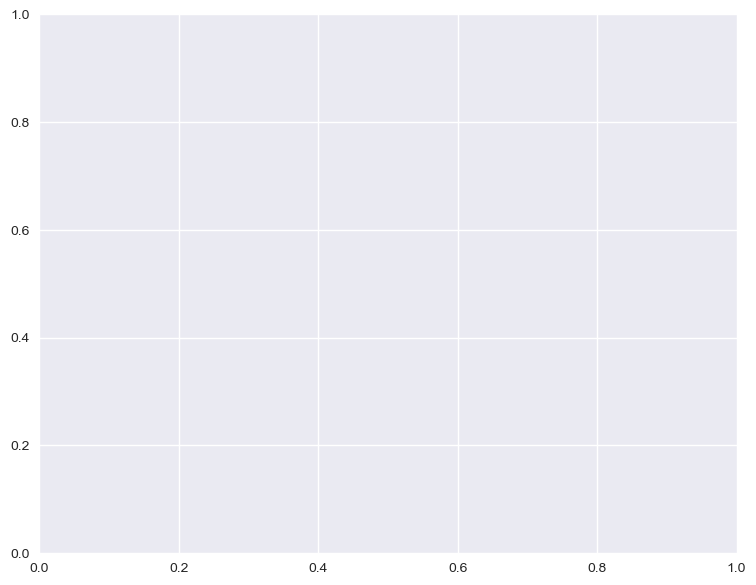

In [10]:

"""Plot Peaks"""
plt.figure()
plt.title("Fourier-Transform Peaks (Temperature)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.grid(True)

# Farbsätze aus MATLAB übernehmen
color_45C = [0, 0.4470, 0.7410]  # Blau
color_25C = [0.8500, 0.3250, 0.0980]  # Orange

# Hilfsfunktion: Peaks plotten
def plot_peaks(table, idx, color, n1, n2):
    t, T, I, U = create_dataset(table, idx)
    T_F, f = fastfourier(T, 0.0005, 0.007)

    # Hole die gewünschten Peaks
    pf1, pv1 = find_peaks_custom(T_F, n1)
    pf2, pv2 = find_peaks_custom(T_F, n2)

    # Zeichne Marker
    plt.scatter(f[pf1], pv1, s=60, color=color, label=f'{table} #{idx} Peak {n1}')
    plt.scatter(f[pf2], pv2, s=60, color=color)

    # Vertikale Linien
    plt.plot([f[pf1], f[pf1]], [0, pv1], 'r--')
    plt.plot([f[pf2], f[pf2]], [0, pv2], 'r--')

# ===== Daten bei 45°C =====
plot_peaks(table_b05_3f_45, 1, color_45C, 1, 6)
plot_peaks(table_b05_3f_45, 2, color_45C, 1, 2)
plot_peaks(table_b05_3f_45, 3, color_45C, 1, 2)

# ===== Daten bei 25°C =====
plot_peaks(table_b05_3f_25, 1, color_25C, 1, 2)
plot_peaks(table_b05_3f_25, 2, color_25C, 1, 2)
plot_peaks(table_b05_3f_25, 3, color_25C, 1, 2)
line1 = mlines.Line2D([], [], color=color_25C, marker='.', markersize=15,linestyle='None', label='46Ah05 at 25°C')
line2 = mlines.Line2D([], [], color=color_45C, marker='.', markersize=15,linestyle='None', label='46Ah05 at 45°C')
plt.legend(fontsize=10, loc="best", handles=[line2, line1])

# plt.tight_layout()
plt.show()
#%%

plt.figure()
plt.grid(True)


Delta S plotten, basierend auf alten Daten von Mohan

C:\Users\maxim\AppData\Local\Temp\ipykernel_4644\4161968840.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(SoC, deltaS, '-r', linewidth=1.5, color=(0, 0.4470, 0.7410))


Warnung: Nicht genügend Peaks gefunden! Rückgabe mit NaN.


c:\Users\maxim\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\maxim\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


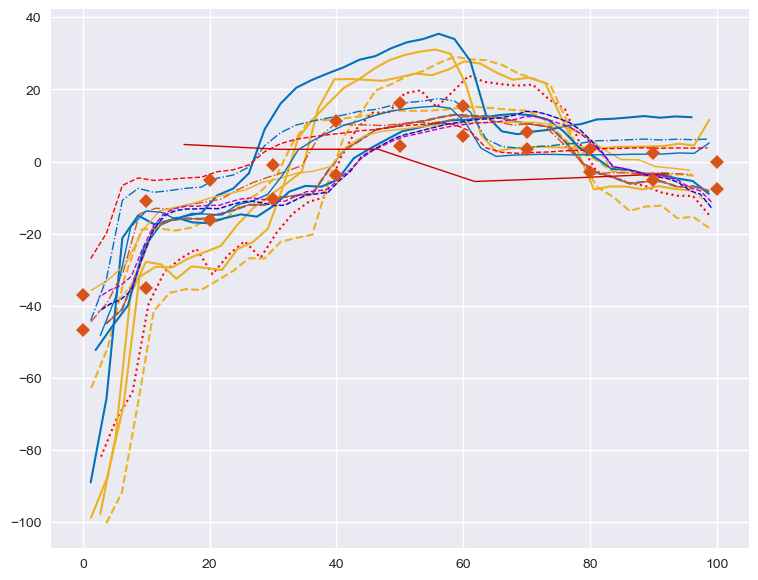

In [11]:

# === independent deltaS ===
# 46Ah05
t, T, I, U = create_dataset(table_b05_46ah_25C, 3)
deltaS, cutoff_start, cutoff_end, mean_T = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, Gth_46_25[5], 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '--', linewidth=1.5, color=(0.9290, 0.6940, 0.1250))

t, T, I, U = create_dataset(table_b05_46ah_35C, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, Gth_46_35[5], 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, ':r', linewidth=1.5)

t, T, I, U = create_dataset(table_b05_46ah_45C, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, Gth_46_45[5], 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '--', linewidth=1.5, color=(0.9290, 0.6940, 0.1250))

t, T, I, U = create_dataset(table_b05_46ah_45C, 3)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, Gth_46_45[5], 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '-', linewidth=1.5, color=(0.9290, 0.6940, 0.1250))

# === 103Ah05 ===
t, T, I, U = create_dataset(table_b05_103ah_45C, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, Gth_103_25[5], 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
deltaS[:len(deltaS)//2] = np.abs(deltaS[:len(deltaS)//2])
plt.plot(SoC, deltaS, '-', linewidth=1.5, color=(0.9290, 0.6940, 0.1250))

t, T, I, U = create_dataset(table_b05_103ah_45C, 3)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, Gth_103_25[5], 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '-r', linewidth=1.5, color=(0, 0.4470, 0.7410))

# === Gth calculation ===
for table, y_value in [
    (table_b05_3f_25, y46discharge[5]),
    (table_b05_3f_45, y46discharge[5]),
    (table_b0646_1f_45_60SOC, y46discharge[5]),
    (table_b05103_3f_25, y103discharge[5]),
    (table_b05103_3f_45, y103discharge[5])
]:
    t, T, I, U = create_dataset(table, 2)
    G_th = calculate_Gth(T, I, 0.0018, y_value)
 
    
# === integrated deltaS ===
# 46Ah05
t, T, I, U = create_dataset(table_b05_3f_25, 2)  # 50% SOC
G_th = calculate_Gth(T, I, 0.0018, y46discharge[5])
t, T, I, U = create_dataset(table_b05_46ah_25C, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '-', linewidth=1.5, color=[0, 0.4470, 0.7410])

t, T, I, U = create_dataset(table_b05_3f_45, 2)
G_th = calculate_Gth(T, I, 0.0018, y46discharge[5])
t, T, I, U = create_dataset(table_b05_46ah_45C, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '--', linewidth=1.5, color=[0, 0.4470, 0.7410])

t, T, I, U = create_dataset(table_b05_3f_45, 2)
G_th = calculate_Gth(T, I, 0.0018, y46discharge[5])
t, T, I, U = create_dataset(table_b05_46ah_45C, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '-', linewidth=1, color=[0.8500, 0.3250, 0.0980])
Ah_dis_46 = used_capacity(t, T, I, U)

t, T, I, U = create_dataset(table_b05_3f_45, 2)
G_th = calculate_Gth(T, I, 0.0018, y46discharge[5])
t, T, I, U = create_dataset(table_b05_46ah_45C, 3)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '-.', linewidth=1, color=[0.8500, 0.3250, 0.0980])
Ah_ch_46 = used_capacity(t, T, I, U)

# 46Ah06Iso
t, T, I, U = create_dataset(table_b0646_1f_45_60SOC, 3)
G_th = calculate_Gth(T, I, 0.0018, y46discharge[6])
t, T, I, U = create_dataset(table_b06_46ah_45C, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '--', linewidth=1, color=[0.9290, 0.6940, 0.1250])

t, T, I, U = create_dataset(table_b0646_1f_45_60SOC, 3)
G_th = calculate_Gth(T, I, 0.0018, y46discharge[6])
t, T, I, U = create_dataset(table_b06_46ah_45C, 3)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '-', linewidth=1, color=[0.9290, 0.6940, 0.1250])

# 103Ah05
t, T, I, U = create_dataset(table_b05103_3f_45, 2)
G_th = calculate_Gth(T, I, 0.0018, y103discharge[5])
t, T, I, U = create_dataset(table_b05_103ah_45C, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
deltaS[:len(deltaS)//2] = np.abs(deltaS[:len(deltaS)//2])
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '-', linewidth=1, color=[0, 0.4470, 0.7410])
Ah_dis_103 = used_capacity(t, T, I, U)

t, T, I, U = create_dataset(table_b05103_3f_45, 2)
G_th = calculate_Gth(T, I, 0.0018, y103discharge[5])
t, T, I, U = create_dataset(table_b05_103ah_45C, 3)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '-.', linewidth=1, color=[0, 0.4470, 0.7410])
Ah_ch_103 = used_capacity(t, T, I, U)

t, T, I, U = create_dataset(table_b05103_3f_25, 2)
G_th = calculate_Gth(T, I, 0.0018, y103discharge[5])
t, T, I, U = create_dataset(table_b07_103ah_25C, 3)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '-', linewidth=1)

t, T, I, U = create_dataset(table_b05_3f_25, 2)
G_th = calculate_Gth(T, I, 0.0018, y46discharge[5])
t, T, I, U = create_dataset(table_b05_103ah_45C, 3)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '--r', linewidth=1)

t, T, I, U = create_dataset(table_b0646_1f_45_60SOC, 3)
G_th = calculate_Gth(T, I, 0.0018, y46discharge[6])
t, T, I, U = create_dataset(table_b06_46ah_45C_iso, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 2)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '--b', linewidth=1)

t, T, I, U = create_dataset(table_b0646_1f_45_70SOC, 3)
G_th = calculate_Gth(T, I, 0.0018, y46discharge[7])
t, T, I, U = create_dataset(table_b06_46ah_45C_iso, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th * np.exp(-1j * 45 / 2 / np.pi), 2)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '--m', linewidth=1)

# potentiometric deltaS
plt.plot(x, y103discharge, marker='D', linestyle='none', linewidth=1.5, color=[0.8500, 0.3250, 0.0980])
plt.plot(x, y46charge, marker='D', linestyle='none', linewidth=1.5, color=[0.8500, 0.3250, 0.0980])
plt.grid(True)
plt.show()

Delta S für die neuen Daten plotten

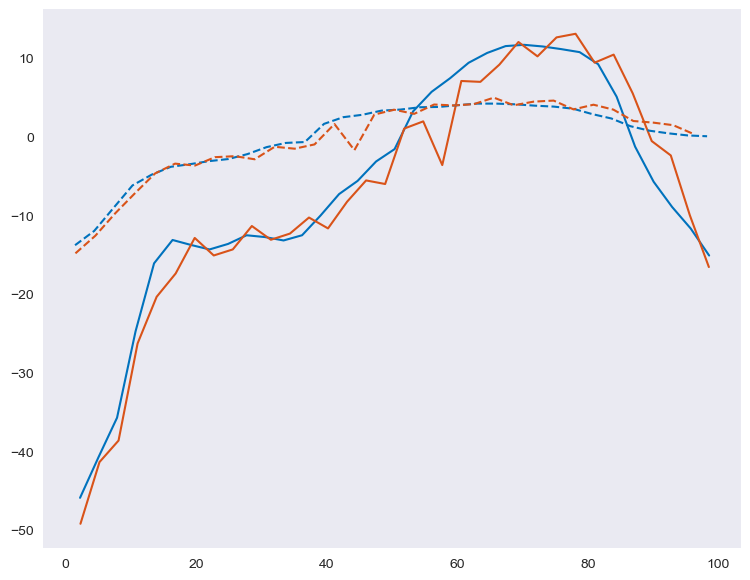

In [12]:
"""für neue Daten"""   

t, T, I, U = create_dataset(table_b05_3f_25, 2)  # 50% SOC
G_th = calculate_Gth(T, I, 0.0018, y46discharge[5])
t, T, I, U = create_dataset(data_46ah_06_preTISdS, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '-', linewidth=1.5, color=[0, 0.4470, 0.7410])


t, T, I, U = create_dataset(table_b05_3f_25, 2)  # 50% SOC
G_th = calculate_Gth(T, I, 0.0018, y46discharge[5])
t, T, I, U = create_dataset(data_46ah_6_delSage2, 2)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '-', linewidth=1.5, color=[0.8500, 0.3250, 0.0980])


t, T, I, U = create_dataset(table_b05_3f_25, 2)  # 50% SOC
G_th = calculate_Gth(T, I, 0.0018, y46charge[5])
t, T, I, U = create_dataset(data_46ah_06_preTISdS, 3)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '--', linewidth=1.5, color=[0, 0.4470, 0.7410])


t, T, I, U = create_dataset(table_b05_3f_25, 2)  # 50% SOC
G_th = calculate_Gth(T, I, 0.0018, y46charge[5])
t, T, I, U = create_dataset(data_46ah_6_delSage2, 3)
deltaS, cutoff_start, cutoff_end,_ = calculate_deltaS_in_SOC_resolution(T, I, 0.0018, G_th, 3)
SoC = np.linspace(100 * cutoff_start, 100 * cutoff_end, len(deltaS))
plt.plot(SoC, deltaS, '--', linewidth=1.5, color=[0.8500, 0.3250, 0.0980])

plt.grid()
plt.show()
